# <center> Punchlines as Mirrors: Social Attitudes, Politics, and Biases in the *The New Yorker* Caption Contest

Humor reflects society’s views, stereotypes, and political climate. The New Yorker Caption Contest offers a unique lens into this process, showing what people find acceptable, absurd, or taboo.

**Narrative Flow**:

- **Introduction:** The Caption Contest as a cultural mirror — humor as social data.
- **Axis 1:** What Is Considered Funny
- **Axis 2:** Professions & politics → humor about authority and power
- **Axis 3:** Social norms → gender roles
- **Conclusion:** Humor not only entertains — it reveals evolving attitudes, biases, and the cultural pulse of society.
---

In [ ]:
# The necessary packages for this notebook
import sys
import os

# Data manipulation
import numpy as np
import pandas as pd
import pickle
import joblib
from scipy.sparse import load_npz
import ast

# Statistical analysis
import scipy.stats as stats
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt


# <center> Professions And Politics

The aim of this axis is to tell a data story: *How do occupations occur in captions and what is their effect on their performance in the competition?*. This is by no means a simple task, but can be easily broken down into segments that make it easier to swallow. An occupational database was created previously, and is going to form the basis of the research of occupations that occur in the captions. The method to identify the occupations is by checking if they are directly mentioned: we cannot account for implied meaning, as it does not come so easily to algorithms as it comes to humans. We realsie this limits the research, and we will keep it mind for future analyses.
---

# <center> All data files previously created with their column names and what each column represents. This is summarised by the use of ChatGPT.
The occupational database is contained in the file called: ``final_combined_occupations.csv`` in the data folder. It can be read from this file by: "../../data/final_combined_occupations.csv".

The ``../../data/data_prepared_v2.pkl`` is a database of the competitions, where the captions were only lightly cleaned for the bag of words, while ``data/cleaned_data_nouns_with_occupations.pkl`` is the database that had a much heavier cleaning by having some form of lemmatising, fixing for typos, removing punctuation and so forth. It also has a column which contains the noun count in to form of a dictionary. Singular and plural terms were accounted for as being the same job already when preparing this count. A useful step is to merge these two datasets together, and save them as a single pickle, while deleting the other two.

``occupation_analysis_df`` refers to a new dataframe which was created by having as columns: ['Occupation_Term', 'Caption_Count' , 'Avg_Funniness', 'Std_Funniness', 'Contests', 'Num_Contests']

In [ ]:
#reload data to continue analysis
with open('../../data/data_prepared_v2.pkl', "rb") as f:
    official_stored_data_loaded = pickle.load(f)
print("Reprocessed official data loaded successfully.")
dataA_v2 = official_stored_data_loaded["dataA"]
dataC_v2 = official_stored_data_loaded["dataC"]

#open the pickle
with open('../../data/cleaned_data_nouns_with_occupations.pkl', "rb") as f:
    noun_stored_data_loaded = pickle.load(f)

dataA_nouns = noun_stored_data_loaded["dataA_nouns"]
dataC_nouns = noun_stored_data_loaded["dataC_nouns"]
dataA_startID = noun_stored_data_loaded["dataA_startID"]
dataA_endID = noun_stored_data_loaded["dataA_endID"]
dataC_lastGoodID = noun_stored_data_loaded["dataC_lastGoodID"]

#read occupation analysis
occupation_analysis_df = pd.read_csv("occupation_analysis.csv")
print("Occupation analysis data loaded successfully.")



vectorizer = joblib.load("vectorizer.joblib")


tfidf_matrix = load_npz("tfidf_matrix.npz")
print("TF-IDF matrix loaded successfully.")
occupation_indices = np.load("occupation_indices.npy")
print("Occupation indices loaded successfully.")
occupation_counts = np.load("occupation_counts.npy")
print("Occupation counts loaded successfully.")

feature_names = np.array(vectorizer.get_feature_names_out())
    
# Funniness metric is "mean" for now.
funniness_metric=  'mean'
documents = []
all_funniness = []
all_contest_ids = []

for i in range(len(dataA_v2)):
    df = dataA_v2[i]
    df['contest_id'] = i * np.ones(len(df), dtype=int)
    documents.extend(df['cleaned_caption_v2'].tolist())
    all_funniness.extend(df[funniness_metric].tolist())
    all_contest_ids.extend(df['contest_id'].tolist())  # make sure this column exists

Reprocessed official data loaded successfully.
Occupation analysis data loaded successfully.
TF-IDF matrix loaded successfully.
Occupation indices loaded successfully.
Occupation counts loaded successfully.


In [ ]:
#load occupations
df_occupations = pd.read_csv("final_combined_occupations.csv")

# Convert each string to a Python list
df_occupations['Synonyms'] = df_occupations['Synonyms'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# create mapping from singular term to plural. We already have this in occupational data
# Create a mapping from synonym to occupation
occupations = df_occupations['Occupation']
synonyms_list = df_occupations['Synonyms'].tolist()

syn_to_occ = {
    synonym.lower(): occ
    for occ, synonyms in zip(occupations, synonyms_list)
    for synonym in synonyms
}

# Subset TF-IDF matrix to only occupation columns
occupation_tfidf_matrix = tfidf_matrix[:, occupation_indices]

# Count the number of captions where each occupation appears (non-zero entries)
occupation_counts_nonzero = (occupation_tfidf_matrix > 0).sum(axis=0)  # still a matrix

# Convert to 1D numpy array
occupation_counts_nonzero = np.array(occupation_counts_nonzero).flatten()

#Add the plural occupations into the singular versions, and only keep the singular versions
occupation_count_dict = {}
for idx, count in zip(occupation_indices, occupation_counts_nonzero):
    term = feature_names[idx]
    if term in syn_to_occ:
        singular_occ = syn_to_occ[term]
        if singular_occ in occupation_count_dict:
            occupation_count_dict[singular_occ] += count
        else:
            occupation_count_dict[singular_occ] = count

# Convert to Series for easier handling
occupation_count_series = pd.Series(occupation_count_dict)

#manual correction for boss which was turned into bos
if 'bos' in occupation_count_series.index:
    occupation_count_series['boss'] = occupation_count_series.get('boss', 0) + occupation_count_series['bos']
    occupation_count_series = occupation_count_series.drop('bos')

In [6]:
# save this table
occupation_analysis_df.to_csv("occupation_analysis.csv", index=False)

Verifying this is correctly done by seeing if the counts still match the previous plot.

In [7]:
# Preview top 20 occupations
occupation_analysis_df.head(50)

,Occupation_Term,Caption_Count,Avg_Funniness,Std_Funniness,Contests,Num_Contests
0,clown,5922,1.203861,0.109239,"{0, 1, 4, 6, 10, 11, 13, 18, 19, 20, 23, 25, 2...",196
1,boss,5828,1.189273,0.122320,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...",332
2,doctor,5469,1.197929,0.123528,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",338
3,president,4861,1.216805,0.131517,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",365
4,lawyer,4255,1.227347,0.139901,"{0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...",284
5,chef,4187,1.223371,0.121645,"{6, 12, 16, 19, 21, 22, 23, 24, 30, 34, 41, 43...",155
6,owner,3440,1.232109,0.123308,"{5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19...",286
7,cook,2361,1.203079,0.119353,"{0, 1, 2, 3, 4, 6, 7, 8, 9, 12, 14, 16, 17, 19...",323
8,ceo,2125,1.174508,0.105135,"{0, 1, 3, 6, 7, 8, 10, 11, 15, 17, 18, 23, 24,...",178
9,judge,2125,1.206314,0.149055,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15,...",325


A dataframe that contains all the caption, their funniness and the contest id.

In [11]:
from scipy.stats import zscore
def compute_funny_ranking(data, by_image=False):
    """
    Compute humor ranking metrics for caption data.
    
    Parameters
    ----------
    data : pd.DataFrame or list[pd.DataFrame]
        Either a single merged dataframe or a list of dataframes per image.
    by_image : bool, optional (default=False)
        If True, compute rankings within each image dataframe in the list.
        If False, compute one global ranking on the merged dataframe.
        
    Returns
    -------
    pd.DataFrame or list[pd.DataFrame]
        DataFrame(s) with additional columns:
        ['funny_score', 'rank_funny']
    """
 
    def _compute(df):
        df = df.copy()

        # Proportions
        df['funny_over_total'] = df['funny'] / df['votes']
        df['unfunny_over_total'] = df['not_funny'] / df['votes']

        # Weighted z-scores
        df['funny_z'] = zscore(df['funny_over_total'] * np.log1p(df['votes']))
        df['not_funny_z'] = zscore(df['unfunny_over_total'] * np.log1p(df['votes']))

        # Combined metric and rank
        df['funny_score'] = df['funny_z'] - df['not_funny_z']
        df[f'rank_funny_{level}'] = df['funny_score'].rank(ascending=False, method='max') #'method="max"' assigns tied scores the highest (max) rank among the ties,
                                                                                             # ensuring integer ranks (no fractional values).
        # Remove columns not longer usefull
        df = df.drop(columns=['funny_over_total', 'unfunny_over_total','funny_z','not_funny_z'])
        return df

    # If working with multiple images
    if by_image:
        level = 'image'
        return [_compute(df) for df in data]
    else:
        level = 'overall'
        return _compute(data)

So, In order to compare if a caption is funny compared to all the captions in that current contest, we still need to check funny relative to others within the same contest.

In [20]:
dataA_ranked = compute_funny_ranking(dataA_v2, by_image=True)

documents = []
all_funny_score = []
all_contest_ids = []

for i, df in enumerate(dataA_ranked):
    df["contest_id"] = i
    
    documents.extend(df["cleaned_caption_v2"].tolist())
    all_funny_score.extend(df["funny_score"].tolist())
    all_contest_ids.extend(df["contest_id"].tolist())

captions_df = pd.DataFrame({
    "caption": documents,
    "funny_score": all_funny_score,
    "contest_id": all_contest_ids,
})

captions_df["funny_score_centered"] = (
    captions_df["funny_score"] -
    captions_df.groupby("contest_id")["funny_score"].transform("mean")
)

In [23]:
# Initialize dictionary
occupation_contests_dict = {occ: set() for occ in occupation_count_series.index}
occupation_funny_centered_dict = {occ: [] for occ in occupation_count_series.index}

# Iterate over captions once
for idx, doc in enumerate(documents):
    doc_lower = doc.lower()
    contest_id = all_contest_ids[idx]
    fun_centered = captions_df.loc[idx, "funny_score_centered"]   # <-- NEW METRIC
    
    for occ in occupation_count_series.index:
        occ_lower = occ.lower()
        if occ_lower in doc_lower:
            occupation_contests_dict[occ].add(contest_id)
            occupation_funny_centered_dict[occ].append(fun_centered)

# Build dataframe
occupation_analysis_df = pd.DataFrame({
    "Occupation_Term": occupation_count_series.index,
    "Caption_Count": occupation_count_series.values,
    
    # raw centered average
    "Avg_Funny_Centered": [
        np.mean(occupation_funny_centered_dict[occ]) 
        if occupation_funny_centered_dict[occ] else 0.0
        for occ in occupation_count_series.index
    ],
    
    # std of centered scores
    "Std_Funny_Centered": [
        np.std(occupation_funny_centered_dict[occ]) 
        if occupation_funny_centered_dict[occ] else 0.0
        for occ in occupation_count_series.index
    ],
    
    # contests where it appears
    "Contests": [occupation_contests_dict[occ] for occ in occupation_count_series.index]
})

# Number of contests
occupation_analysis_df["Num_Contests"] = occupation_analysis_df["Contests"].apply(len)

# Sort
occupation_analysis_df = occupation_analysis_df.sort_values(
    by="Caption_Count", ascending=False
).reset_index(drop=True)

occupation_analysis_df.head(20)


,Occupation_Term,Caption_Count,Avg_Funny_Centered,Std_Funny_Centered,Contests,Num_Contests
0,clown,5922,-0.079906,1.235287,"{0, 1, 4, 6, 10, 11, 13, 18, 19, 20, 23, 25, 2...",196
1,boss,5828,-0.134886,1.271115,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...",332
2,doctor,5469,-0.119316,1.292717,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",338
3,president,4861,-0.057399,1.413229,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",365
4,lawyer,4255,0.078447,1.421459,"{0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...",284
5,chef,4187,-0.035563,1.457339,"{6, 12, 16, 19, 21, 22, 23, 24, 30, 34, 41, 43...",155
6,owner,3440,0.056988,1.505547,"{5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19...",286
7,cook,2361,-0.134927,1.227482,"{0, 1, 2, 3, 4, 6, 7, 8, 9, 12, 14, 16, 17, 19...",323
8,ceo,2125,-0.167946,1.085491,"{0, 1, 3, 6, 7, 8, 10, 11, 15, 17, 18, 23, 24,...",178
9,judge,2125,-0.041058,1.720249,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15,...",325


In [24]:
#save the table 
occupation_analysis_df.to_csv("occupation_analysis.csv", index=False)

In [25]:
#load the table
occupation_analysis_df = pd.read_csv("occupation_analysis.csv")
print("Occupation analysis data loaded successfully.")

Occupation analysis data loaded successfully.


---
# <center> Part 1: Occupation frequency and Distribution

This section will focus on the frequency of occupations referenced by occupants. It will plot the most common jobs, and then analyse if there are any which occur rarely, but score really well.

There are three graphs that I will produce here:
1. Bar chart of the top 20.
2. Histogram of occupation frequencies on a log scale
3. Number of contests each top occupation appears in
4. Number of contest each occupation appears in, descending order (+ support)

The final point will show us if there are some jobs which occur in many contexts, meaning that they are universally used, while less frequent occurences must be tied to specific scenes.

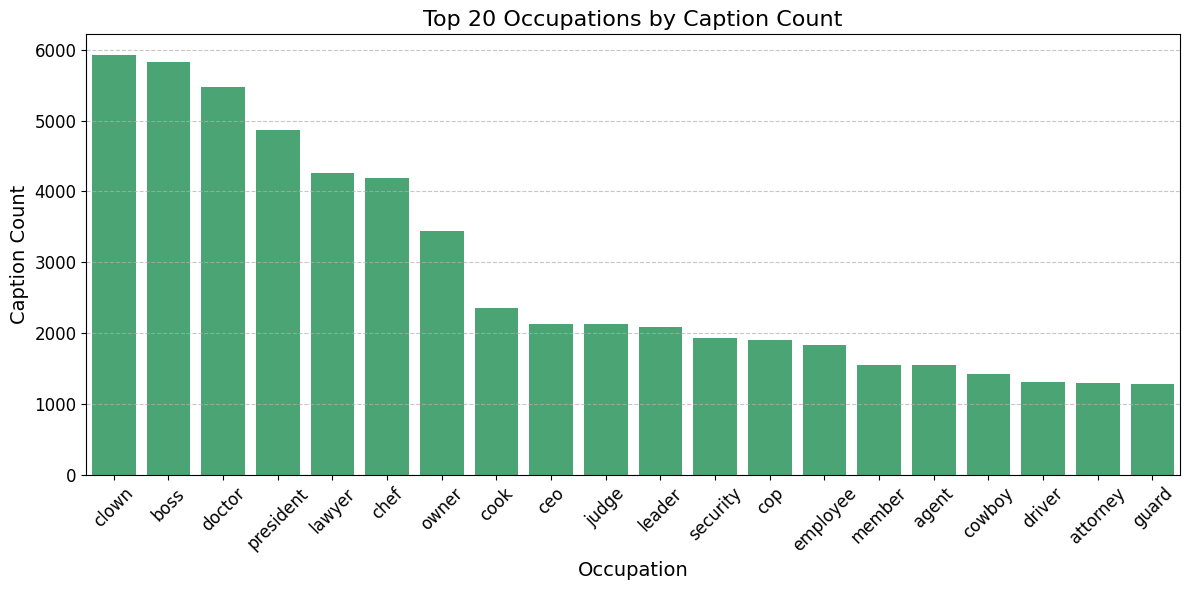

In [30]:
#Graph 1: Top 20 occupations by caption count
plt.figure(figsize=(12, 6))
sns.barplot(
    data=occupation_analysis_df.head(20),
    x="Occupation_Term",
    y="Caption_Count",
    color='mediumseagreen'
)
plt.title("Top 20 Occupations by Caption Count", fontsize = 16)
plt.xlabel("Occupation", fontsize = 14)
plt.ylabel("Caption Count", fontsize = 14)
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

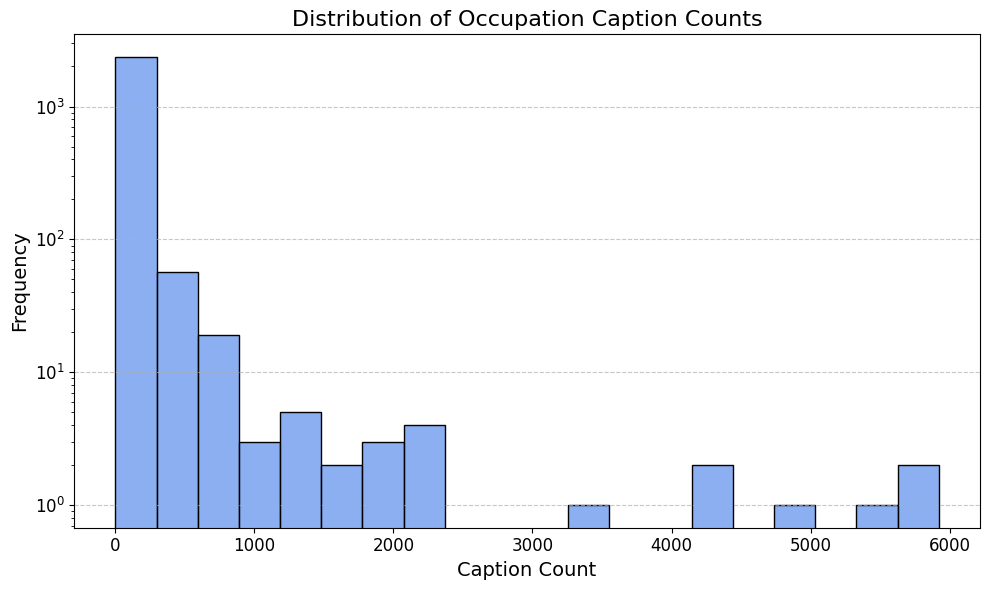

In [41]:
# Graph 2: Histogram of occupation frequencies
plt.figure(figsize=(10, 6))
sns.histplot(
    data=occupation_analysis_df,
    x="Caption_Count",
    bins=20,
    color='cornflowerblue',
)
plt.title("Distribution of Occupation Caption Counts", fontsize=16)
plt.yscale('log')
plt.xlabel("Caption Count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

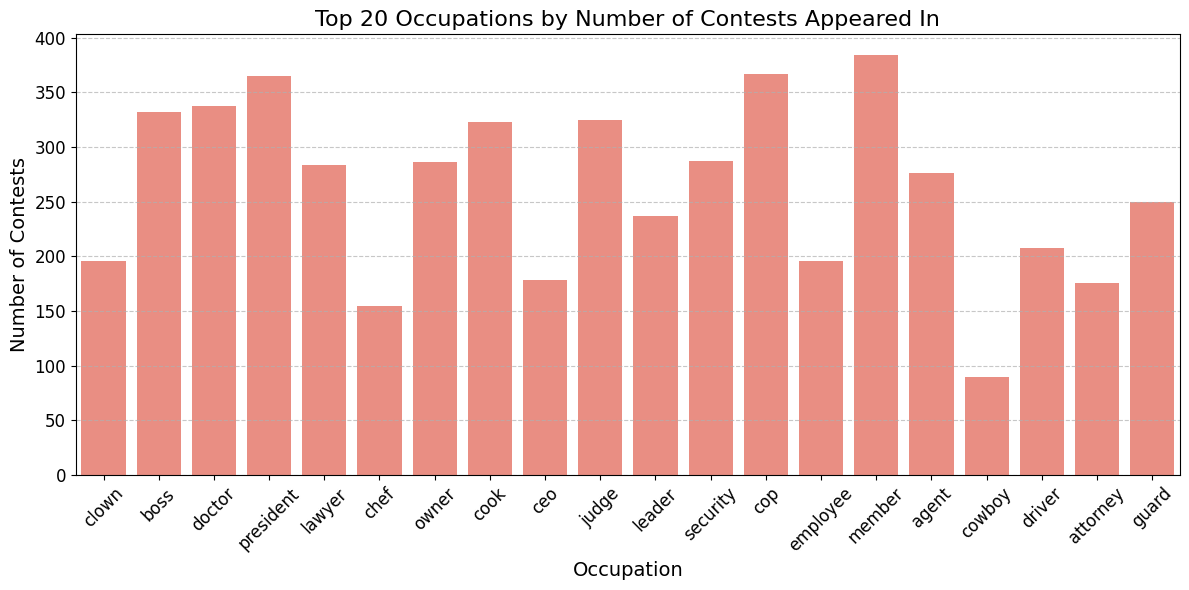

In [ ]:
# Graph 3: Number of contests each top occupation appears in
plt.figure(figsize=(12, 6))
sns.barplot(
    data=occupation_analysis_df.head(20),
    x="Occupation_Term",
    y="Num_Contests",
    color='salmon'
)
plt.title("Top 20 Occupations by Number of Contests Appeared In", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Number of Contests", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [64]:
#some manual cleaning: we need to remove some jobs:
remove = ['m', 'pt', 'lin', 'ta', 'ot', 'od', 'dd', 'ob', 'sider', 'np', 'ager', 'roper', 'dc']
for r in remove:
    occupation_analysis_df = occupation_analysis_df[occupation_analysis_df['Occupation_Term'] != r]

#save the table
occupation_analysis_df.to_csv("occupation_analysis.csv", index=False)

In [65]:
#reload the cleaned table
occupation_analysis_df = pd.read_csv("occupation_analysis.csv")
print("Cleaned occupation analysis data loaded successfully.")

Cleaned occupation analysis data loaded successfully.


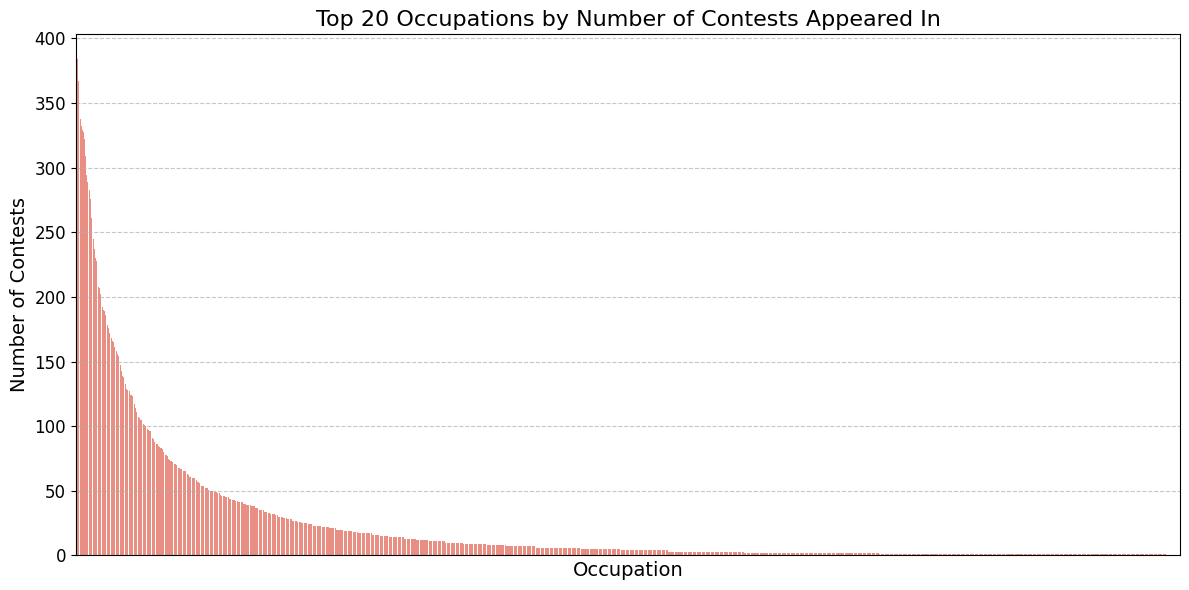

In [67]:
# Graph 4: Number of contest each occupation appears in, descending order

# Sort occupations by number of contests (descending)
top_contests_df = occupation_analysis_df.sort_values(
    by="Num_Contests", ascending=False
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_contests_df,
    x="Occupation_Term",
    y="Num_Contests",
    color='salmon'
)
plt.title("Top 20 Occupations by Number of Contests Appeared In", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Number of Contests", fontsize=14)
plt.xticks([], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

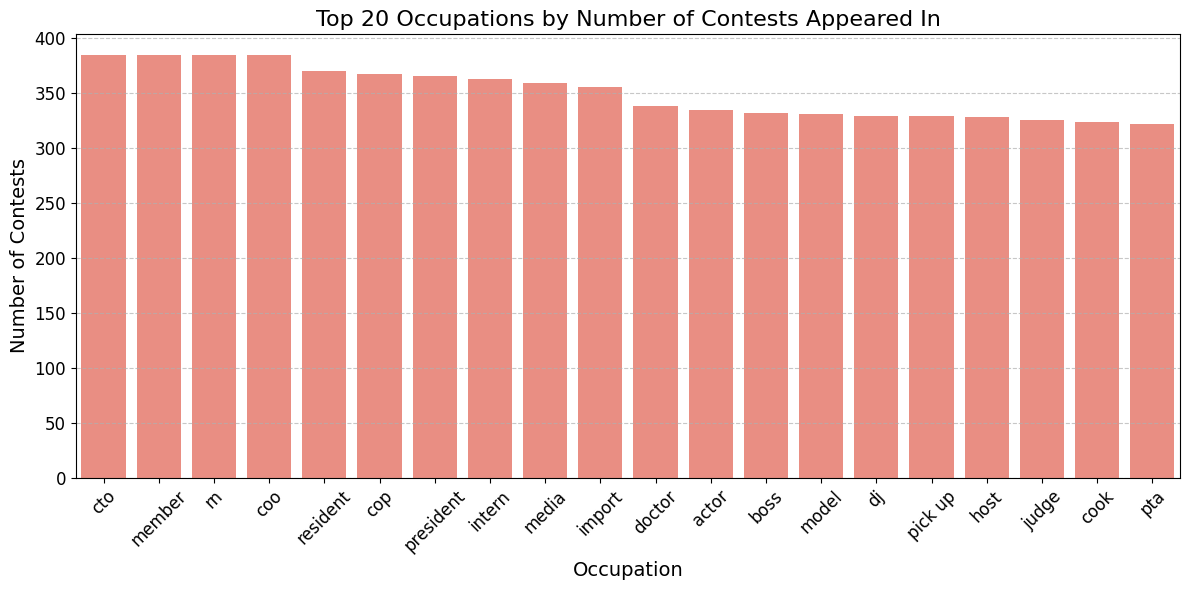

In [68]:
#Support: 

# Sort occupations by number of contests (descending)
top_contests_df = occupation_analysis_df.sort_values(
    by="Num_Contests", ascending=False
).head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_contests_df,
    x="Occupation_Term",
    y="Num_Contests",
    color='salmon'
)
plt.title("Top 20 Occupations by Number of Contests Appeared In", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Number of Contests", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---
# <center> Part 2: How funny is an occupation

We will try to answer here whether captions with certain jobs are funnier than similar captions in the same contest? This will also help show which occupations are most associated with the success of a cpation and show if some jobs consistently perform bad.

I will produce three graphs:

1. A scatterplot of frequency and funniness. This will show if there are rare but funny occupations (top left section), common but unfunny (bottom right), and see if there are common strong performers (top right) + (support stats and plot)

2. A bar chart of the top 20 occupations by funnines. For this, we need to use the centered funnines per caption. To avoid some noise, we can filter to only take into account occupations if they are above a certain threshold. + (2 supports)

3. A bar chart with error bars: Mean and std values of funny score centered. + (support)

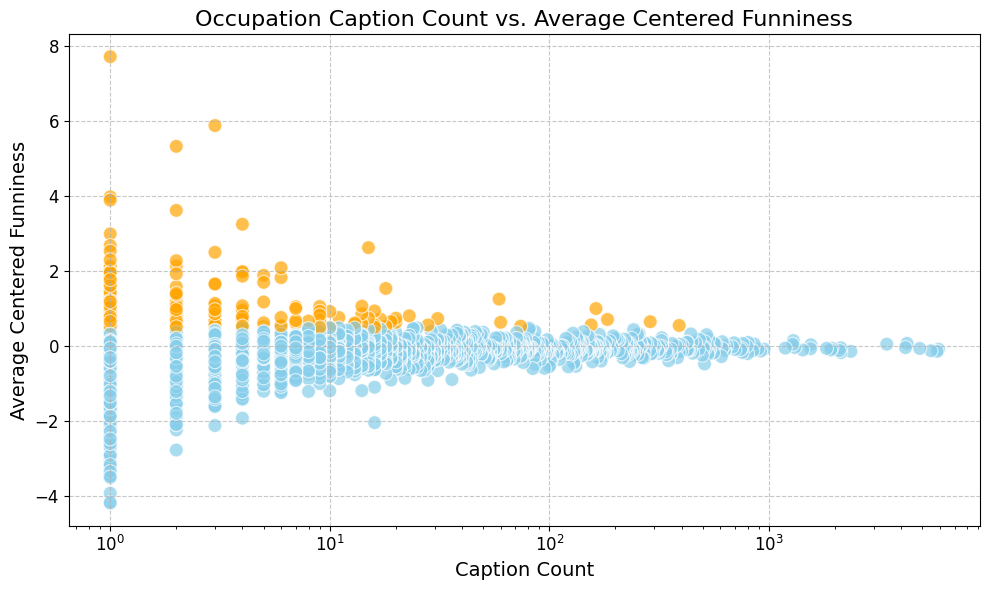

In [75]:
# Graph 1: Scatterlpot of freq vs funniness (centered)

# color code by being above or below a certain threshold
threshold = 0.5 # Adjust this threshold as needed
colors = ['orange' if x >= threshold else 'skyblue' for x in occupation_analysis_df['Avg_Funny_Centered']]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=occupation_analysis_df,
    x="Caption_Count",
    y="Avg_Funny_Centered",
    hue=colors,
    palette=['skyblue', 'orange'],
    legend=False,
    s=100,
    alpha=0.7
)
plt.title("Occupation Caption Count vs. Average Centered Funniness", fontsize=16)
plt.xlabel("Caption Count", fontsize=14)
plt.ylabel("Average Centered Funniness", fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Occupations with Average Centered Funniness above 0.5
priest: 390 occurrences
gatherer: 288 occurrences
mailman: 184 occurrences
branch manager: 163 occurrences
pointer: 155 occurrences
meteorologist: 74 occurrences
head waiter: 60 occurrences
violinist: 59 occurrences
house sitter: 31 occurrences
venture capitalist: 28 occurrences
leg man: 23 occurrences
archeologist: 20 occurrences
airbnb host: 20 occurrences
food processor: 19 occurrences
rope maker: 18 occurrences
window washer: 18 occurrences
corporate lawyer: 17 occurrences
book critic: 16 occurrences
technical support: 16 occurrences
fund raiser: 16 occurrences
department chair: 15 occurrences
cherry pitter: 15 occurrences
neurosurgeon: 14 occurrences
sticker on: 14 occurrences
loan officer: 14 occurrences
english language: 13 occurrences
imam: 13 occurrences
lyft driver: 11 occurrences
patent attorney: 10 occurrences
blotter: 10 occurrences
poll watcher: 9 occurrences
geologist: 9 occurrences
statistician: 9 occurrences
pipe cl

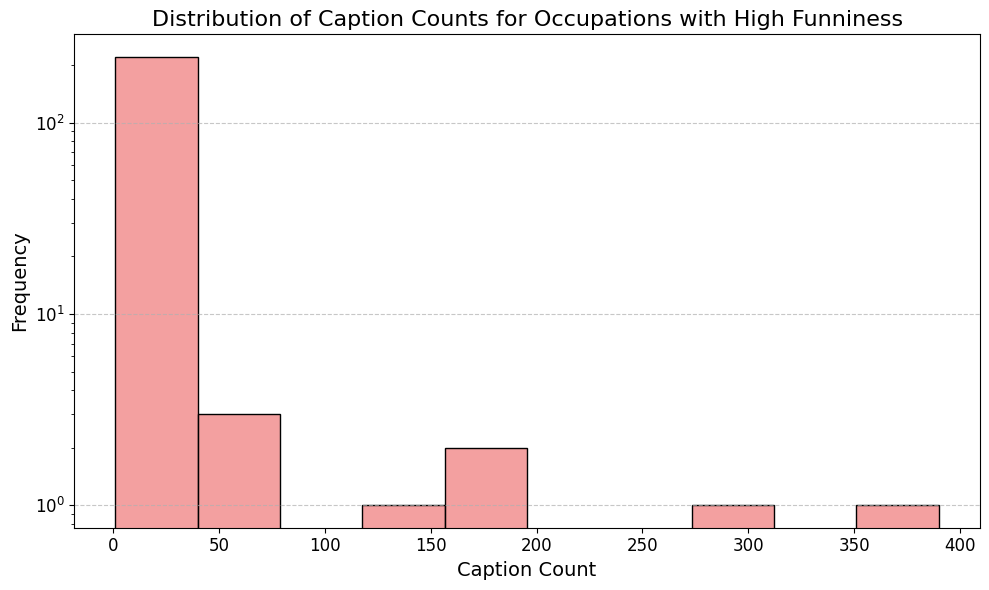

In [76]:
#support: print the occupations above threshold and how many times they occur
above_threshold = occupation_analysis_df[occupation_analysis_df['Avg_Funny_Centered'] >= threshold]
print("Occupations with Average Centered Funniness above", threshold)
for _, row in above_threshold.iterrows():
    print(f"{row['Occupation_Term']}: {row['Caption_Count']} occurrences")

# plot their histogram of occurences
above_threshold = occupation_analysis_df[occupation_analysis_df['Avg_Funny_Centered'] >= threshold]
plt.figure(figsize=(10, 6))
sns.histplot(
    data=above_threshold,
    x="Caption_Count",
    bins=10,
    color='lightcoral',
)
plt.title("Distribution of Caption Counts for Occupations with High Funniness", fontsize=16)
plt.yscale('log')
plt.xlabel("Caption Count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

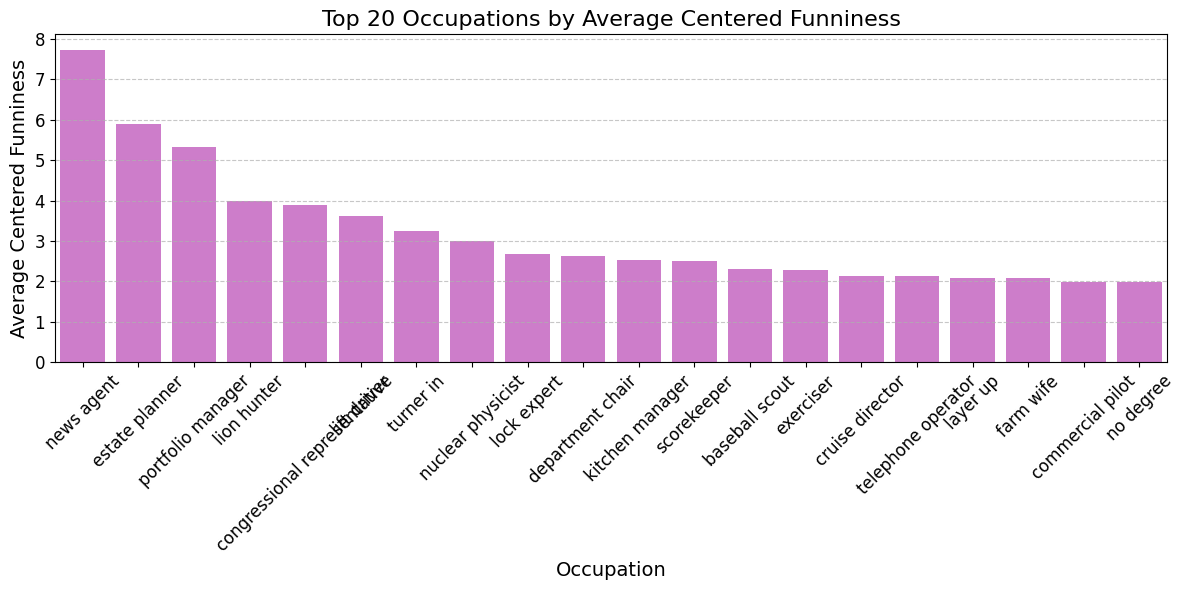

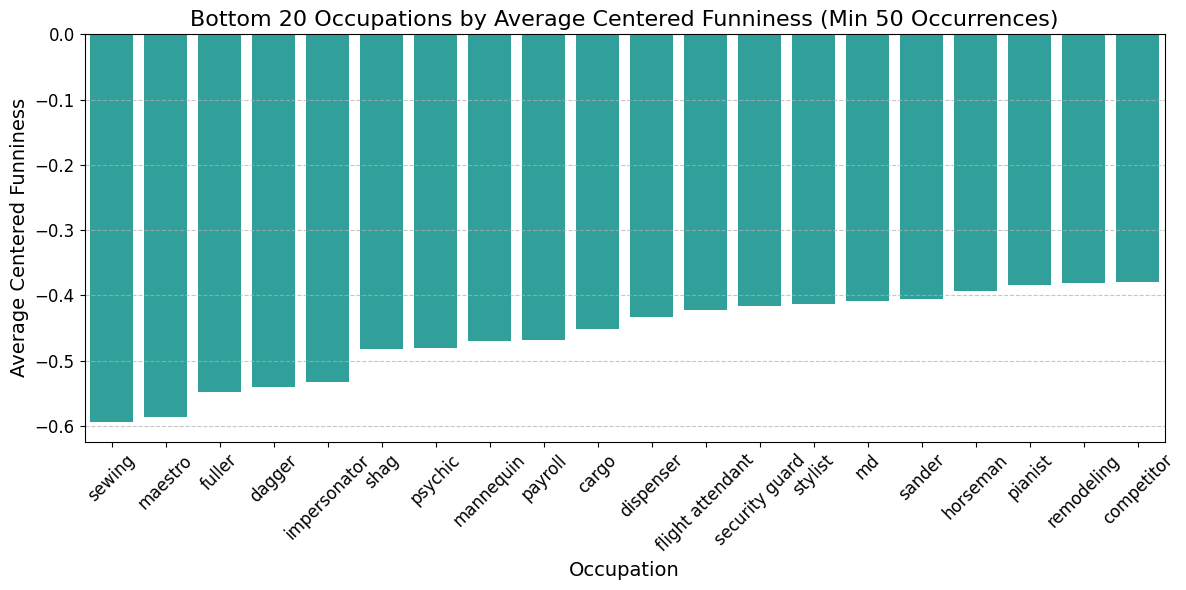

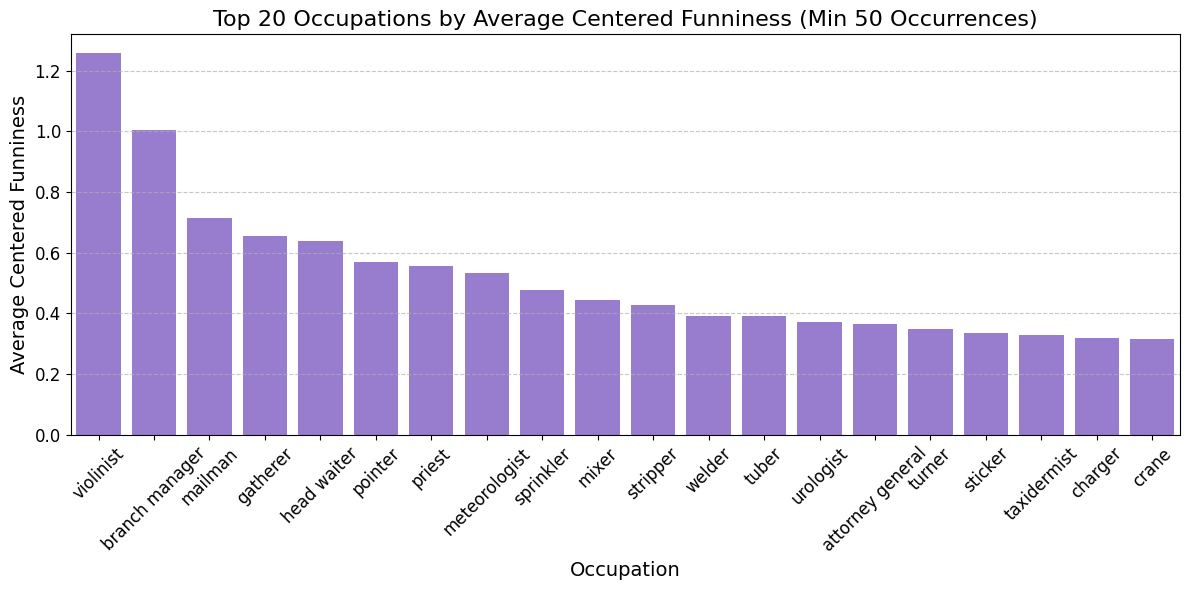

In [79]:
# Graph 2: Top 20 occupations by funniness, no threshold on occurence... may be misleading
plt.figure(figsize=(12, 6))
sns.barplot(
    data=occupation_analysis_df.sort_values(by="Avg_Funny_Centered", ascending=False).head(20),
    x="Occupation_Term",
    y="Avg_Funny_Centered",
    color='orchid'
)
plt.title("Top 20 Occupations by Average Centered Funniness", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Average Centered Funniness", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Support: bootm 20 occupations by funniness, with at least threshold_occ occurrences
threshold_occ = 50
plt.figure(figsize=(12, 6))
sns.barplot(
    data=occupation_analysis_df[occupation_analysis_df['Caption_Count'] >= threshold_occ].sort_values(by="Avg_Funny_Centered").head(20),
    x="Occupation_Term",
    y="Avg_Funny_Centered",
    color='lightseagreen'
)
plt.title(f"Bottom 20 Occupations by Average Centered Funniness (Min {threshold_occ} Occurrences)", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Average Centered Funniness", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Support: top 20 occupations by funniness, with at least threshold_occ occurrences
threshold_occ = 50
plt.figure(figsize=(12, 6))
sns.barplot(
    data=occupation_analysis_df[occupation_analysis_df['Caption_Count'] >= threshold_occ].sort_values(by="Avg_Funny_Centered", ascending=False).head(20),
    x="Occupation_Term",
    y="Avg_Funny_Centered",
    color='mediumpurple'
)
plt.title(f"Top 20 Occupations by Average Centered Funniness (Min {threshold_occ} Occurrences)", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Average Centered Funniness", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

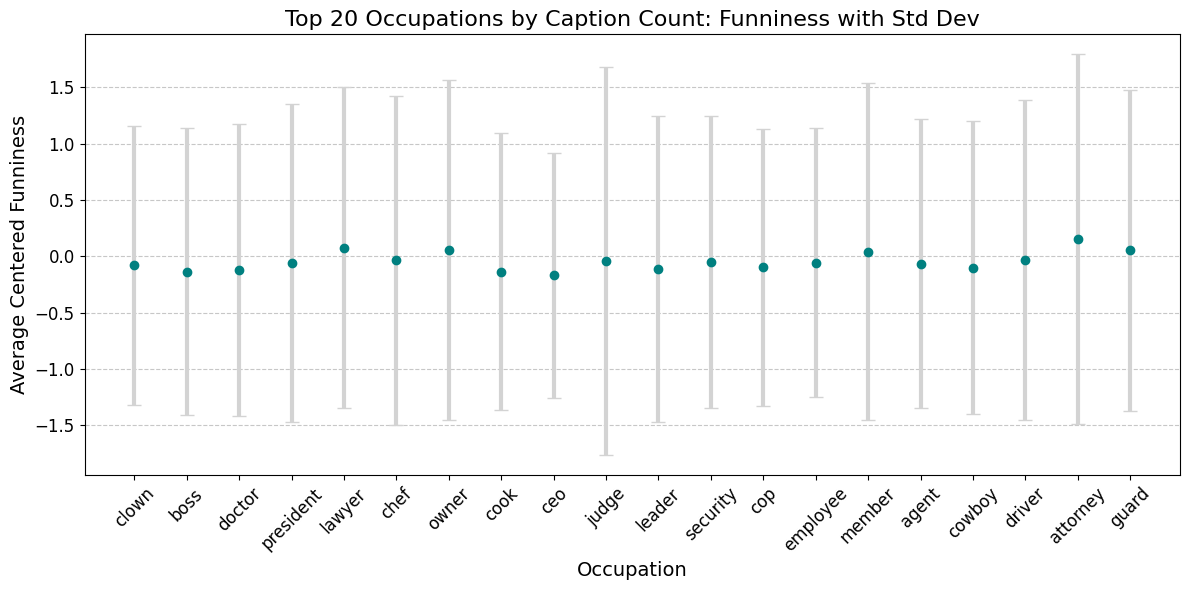

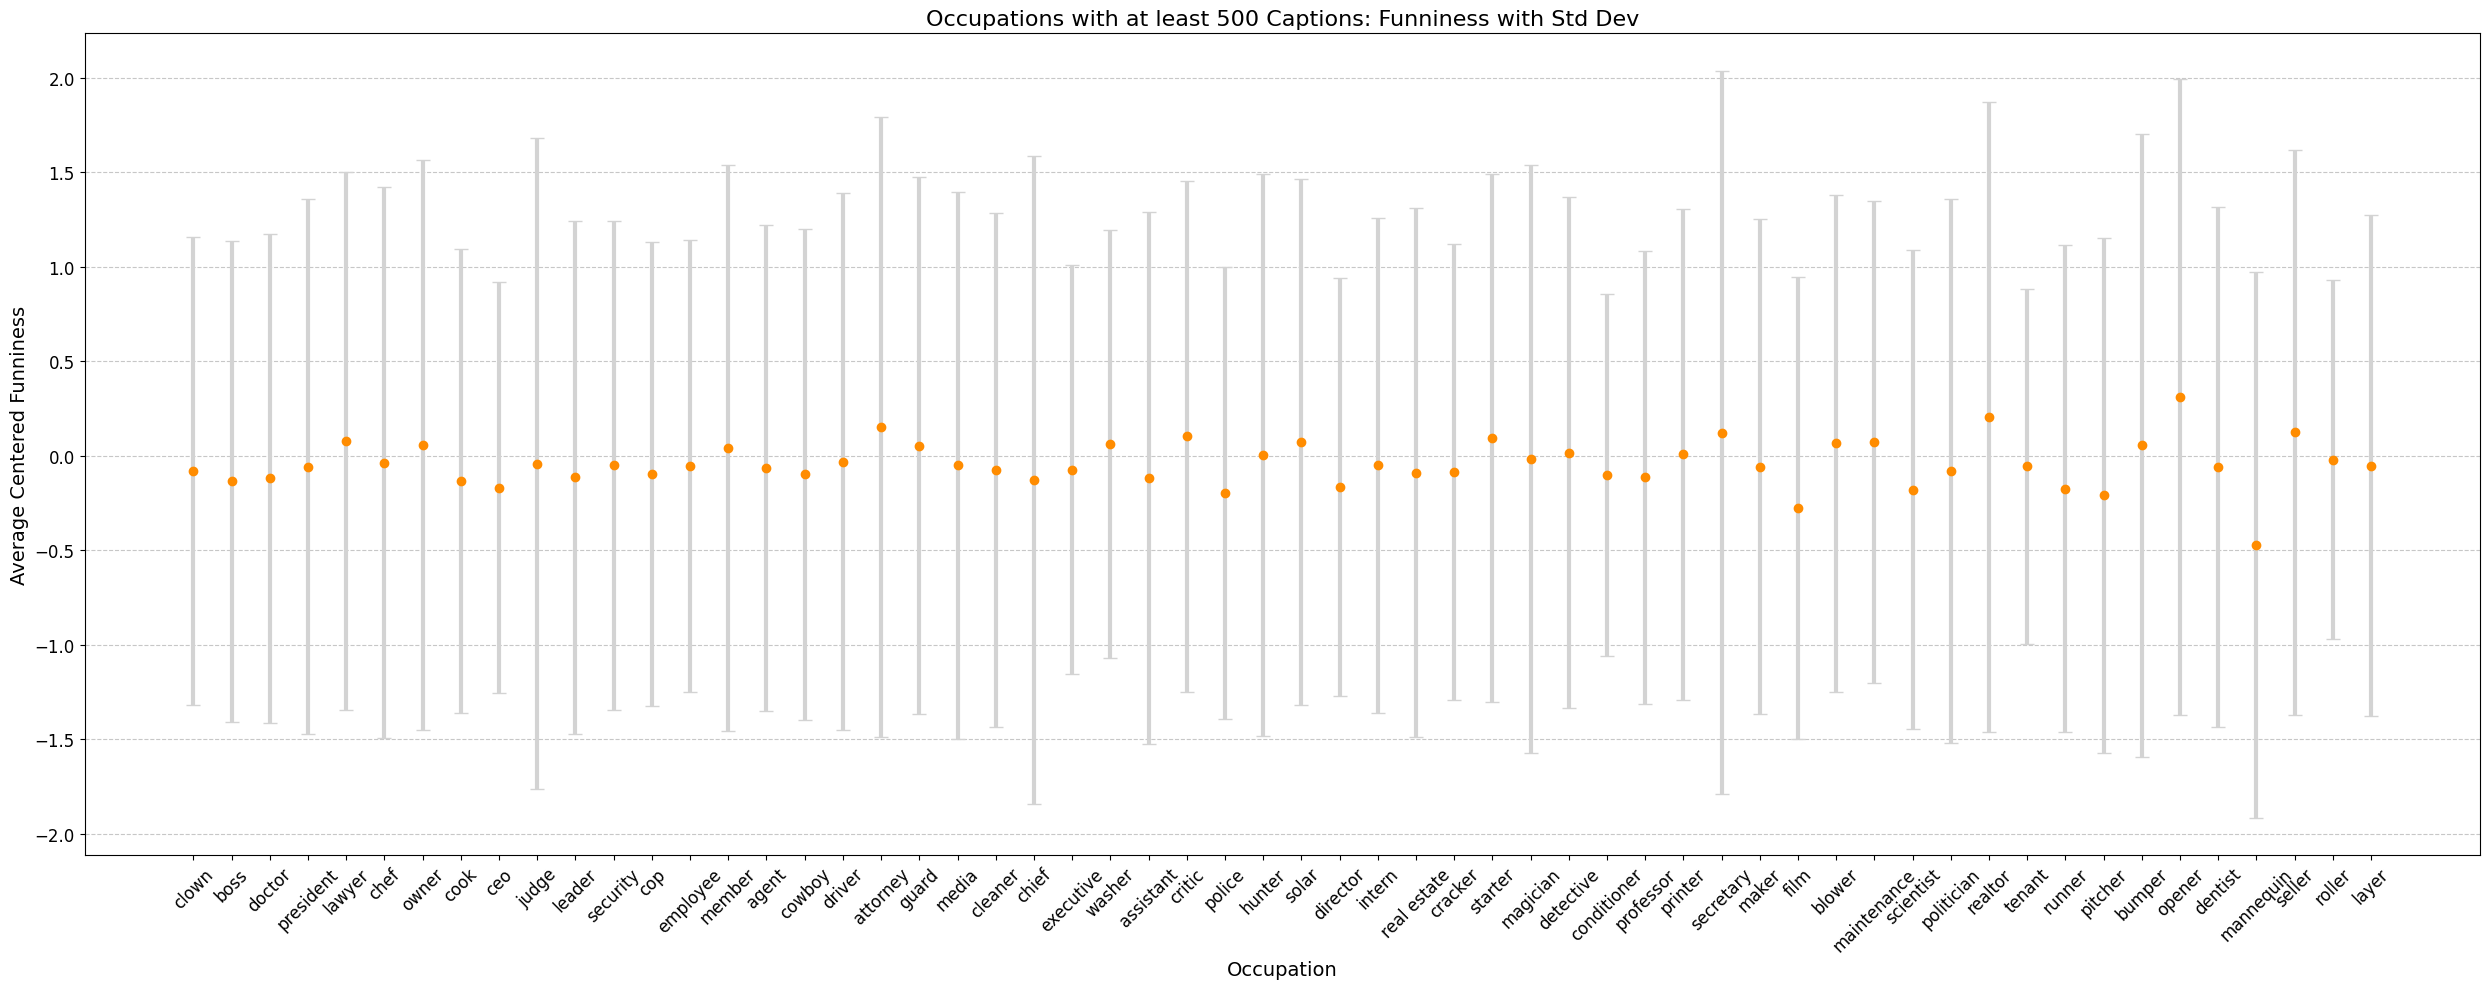

In [83]:
# Graph 3: Error bar plot: mean +/- std dev of funniness for top 20 occupations by caption count
plt.figure(figsize=(12, 6))
top_20_occ = occupation_analysis_df.head(20)
plt.errorbar(
    x=top_20_occ["Occupation_Term"],
    y=top_20_occ["Avg_Funny_Centered"],
    yerr=top_20_occ["Std_Funny_Centered"],
    fmt='o',
    ecolor='lightgray',
    elinewidth=3,
    capsize=5,
    color='teal'
)
plt.title("Top 20 Occupations by Caption Count: Funniness with Std Dev", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Average Centered Funniness", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Support: maybe other error bar plots with different thresholds on occurences
# Graph 4: Error bar plot: mean +/- std dev of funniness for occupations with at least 100 occurrences
threshold_occ = 500
plt.figure(figsize=(25, 10))
filtered_occ = occupation_analysis_df[occupation_analysis_df['Caption_Count'] >= threshold_occ]
plt.errorbar(
    x=filtered_occ["Occupation_Term"],
    y=filtered_occ["Avg_Funny_Centered"],
    yerr=filtered_occ["Std_Funny_Centered"],
    fmt='o',
    ecolor='lightgray',
    elinewidth=3,
    capsize=5,
    color='darkorange'
)
plt.title(f"Occupations with at least {threshold_occ} Captions: Funniness with Std Dev", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Average Centered Funniness", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


---
# <center> Part 3: occupations and their categories.

here we need to list the groups to different fields. To do this, we give the list of around 3000 occupations that were found to ChatGPT to form them into groups. This eliminates the need to manually go through all the occupations and their potential fields. This will allow us to examine if there is a categorical reason behind  certain words.

The identified fields are:
 - Arts & Entertainment
 - Business, Management & Finance
 - Law, Government & Politics
 - Healthcare & Medicine
 - Education & Academia
 - Science & Engineering
 - Trade, Craft & Manufacturing
 - Service Industry & Hospitality
 - Transportation & Logistics
 - Agriculture, Animals & Outdoors
 - Public Safety, Military, Security
 - Sports & Fitness
 - Media, Writing & Communication
 - Domestic & Personal Care
 - Miscellaneous / Unclear / Humorous Jobs

I will produce graphs:
1. Box plot of occupation centered scores of each field.
2. bar chart: mean humour by category to see if some professions are more funny than others.

In [85]:
occupation_categories = {
    "Arts & Entertainment": [
        "clown","magician","artist","pianist","film","performer","art critic","actor","comedian","model",
        "singer","dancer","musician","musical conductor","circus performer","writer","poet","cartoonist",
        "illustrator","dj","screenwriter","playwright","story writer","story reader","fiction writer",
        "concert pianist","trumpeter","soloist","harpist","band leader","vocalist","photographer",
        "camera operator","cinematographer","news anchor","radio announcer","radio commentator","showman",
        "ventriloquist","stagehand","stage manager","puppeteer","master chef","fashion model",
        "fashion stylist","fashion designer","fashion director","fashion coordinator","dresser",
        "costume designer","opera singer","art model","artists model","art director","artistic director",
        "conceptual artist","music teacher","piano player","piano mover","animator","yoga instructor"
    ],
    "Business, Management & Finance": [
        "boss","ceo","owner","executive","chief","manager","assistant","administrator","supervisor",
        "branch manager","department head","project manager","operations manager","investment banker",
        "banker","financier","financial advisor","financial analyst","financial planner","accountant",
        "tax accountant","auditor","internal auditor","consultant","business consultant",
        "marketing consultant","marketing director","sales manager","sales associate","sales representative",
        "sales assistant","store manager","business manager","business analyst","entrepreneur","broker",
        "insurance agent","insurance broker","insurance underwriter","cpa","account executive","asset manager",
        "portfolio manager","investment advisor","vendor","purchaser","buyer","seller"
    ],
    "Law, Government & Politics": [
        "lawyer","attorney","attorney general","judge","justice","prosecutor","public defender",
        "district attorney","trial lawyer","patent attorney","corporate lawyer","criminal lawyer",
        "probate lawyer","legal counsel","legal advisor","legal aide","paralegal","litigator",
        "litigation attorney","politician","senator","us senator","congressman","congressperson",
        "state representative","representative","president","vice president","governor","mayor",
        "commissioner","ambassador","diplomat","legislator","councilman","official","city official",
        "precinct captain","police commissioner"
    ],
    "Healthcare & Medicine": [
        "doctor","dentist","surgeon","chiropractor","physician","physician assistant","cardiologist",
        "pediatrician","nurse","rn","nurse practitioner","medical doctor","medical officer",
        "medical resident","medical writer","medical illustrator","medical consultant",
        "medical technologist","orthodontist","ophthalmologist","optometrist","optician","psychiatrist",
        "psychologist","clinical","mental health","therapist","massage therapist","physical therapist",
        "occupational therapy","emt","paramedic","dietitian","nutritionist","radiologist","virologist",
        "epidemiologist","urologist","proctologist","pathologist","hematologist","dermatologist",
        "anesthesiologist","neurosurgeon","oncologist","veterinarian","podiatrist","speech therapist",
        "speech pathologist"
    ],
    "Education & Academia": [
        "professor","teacher","kindergarten teacher","music teacher","math teacher","school nurse",
        "school counselor","school principal","assistant principal","educator","lecturer","tutor",
        "academic researcher","research scientist","scientist","student nurse","research analyst","mentor",
        "instructor","piano professor"
    ],
    "Science & Engineering": [
        "scientist","biologist","chemist","physicist","astronaut","engineer","software engineer",
        "civil engineer","mechanical engineer","electrical engineer","aerospace engineer",
        "environmental scientist","epidemiologist","geologist","hydrologist","astronomer","astrophysicist",
        "anthropologist","archaeologist","ichthyologist","ornithologist","zoologist","herpetologist",
        "entomologist","economist","statistician","data scientist","data analyst","programmer",
        "network engineer","cloud engineer","cybersecurity","technician","technologist"
    ],
    "Trades, Craft & Manufacturing": [
        "carpenter","mason","plumber","electrician","welder","mechanic","machinist","builder","contractor",
        "construction worker","ironworker","stonemason","bricklayer","roofer","house painter","glass cutter",
        "glass blower","blacksmith","farrier","tool maker","metalworker","engraver","seamstres","tailor",
        "dressmaker","cobbler","upholsterer","woodworker","boat builder","ship carpenter","steamfitter",
        "pipe fitter","painter","sculptor"
    ],
    "Service Industry & Hospitality": [
        "chef","cook","sous chef","barista","bartender","waiter","waitress","server","valet",
        "hotel concierge","housekeeper","maid","janitor","laundry","baker","pastry chef","line cook",
        "butler","doorman","caterer","bar manager","food handler","food processor","delivery driver",
        "tour guide","travel agent","host","hostess","customer service","hairdresser","stylist","manicurist"
    ],
    "Transportation & Logistics": [
        "driver","uber driver","taxi driver","delivery driver","truck driver","bus driver","pilot","co pilot",
        "airline pilot","ship captain","sailor","fisherman","train driver","train conductor",
        "forklift operator","baggage handler","loader","mover","courier","dispatcher","navigator","porter",
        "mail carrier","mailman","postal worker"
    ],
    "Agriculture, Animals & Outdoors": [
        "farmer","rancher","gardener","shepherd","beekeeper","fisher","fisherman","hunter","cowboy",
        "lumberjack","park ranger","forester","tree surgeon","tree trimmer","zookeeper","animal trainer",
        "dog walker","dog trainer","agricultural worker","crop duster","game warden"
    ],
    "Public Safety, Military & Security": [
        "cop","police officer","security guard","guard","prison guard","firefighter","fire chief","marshal",
        "constable","deputy","soldier","military","lifeguard","paramedic","border patrol","parole officer",
        "detective","homicide detective","inspector","first responder","sheriff","policewoman",
        "transit police","state trooper"
    ],
    "Sports & Fitness": [
        "athlete","football player","baseball player","basketball player","skier","swimmer","diver","golfer",
        "tennis player","yoga teacher","fitness instructor","trainer","personal trainer","coach",
        "boxing coach","boxing instructor","umpire","referee","jockey","skateboarder","runner","pitcher",
        "catcher","drummer"
    ],
    "Media, Writing & Communication": [
        "journalist","reporter","columnist","news writer","editor","copyeditor","fact checker","publicist",
        "press secretary","communication officer","commentator","blogger","vlogger","publisher","copywriter",
        "speech writer","screen writer","court stenographer","captioner"
    ],
    "Domestic & Personal Care": [
        "babysitter","nanny","caregiver","housekeeper","house sitter","homemaker","child care","home health aide",
        "personal shopper","personal assistant","personal stylist","life coach","doula"
    ],
    "Miscellaneous / Unclear / Humorous Jobs": []
}

# append Miscellaneous / Unclear / Humorous Jobs with remaining occupations
all_categorized = set()
for cat, occs in occupation_categories.items():
    all_categorized.update(occs) # add all occupations already categorized
for occ in occupation_analysis_df['Occupation_Term']:
    if occ not in all_categorized:
        occupation_categories["Miscellaneous / Unclear / Humorous Jobs"].append(occ) # add uncategorized occupations here

# Map each occupation to its category
occupation_to_category = {}
for category, occupations in occupation_categories.items():
    for occupation in occupations:
        occupation_to_category[occupation] = category
# Add category column to occupation_analysis_df
occupation_analysis_df['Category'] = occupation_analysis_df['Occupation_Term'].map(occupation_to_category)

# Save the categorized occupation analysis
occupation_analysis_df.to_csv("occupation_analysis.csv", index=False)

In [86]:
#load the categorized occupation analysis
occupation_analysis_df = pd.read_csv("occupation_analysis.csv")
print("Categorized occupation analysis data loaded successfully.")

Categorized occupation analysis data loaded successfully.


In [90]:
#Before categorising, we had:
print(f"Total unique occupations before categorization: {len(occupation_analysis_df)}")
#After categorising, we have:
sum = 0
for category in occupation_categories.keys():
    count = occupation_analysis_df[occupation_analysis_df['Category'] == category].shape[0]
    print(f"{category}: {count} occupations")
    sum += count
print(f"Total occupations after categorization: {sum}")

Total unique occupations before categorization: 2455
Arts & Entertainment: 60 occupations
Business, Management & Finance: 47 occupations
Law, Government & Politics: 39 occupations
Healthcare & Medicine: 46 occupations
Education & Academia: 18 occupations
Science & Engineering: 34 occupations
Trades, Craft & Manufacturing: 28 occupations
Service Industry & Hospitality: 29 occupations
Transportation & Logistics: 21 occupations
Agriculture, Animals & Outdoors: 21 occupations
Public Safety, Military & Security: 22 occupations
Sports & Fitness: 24 occupations
Media, Writing & Communication: 17 occupations
Domestic & Personal Care: 12 occupations
Miscellaneous / Unclear / Humorous Jobs: 2037 occupations
Total occupations after categorization: 2455


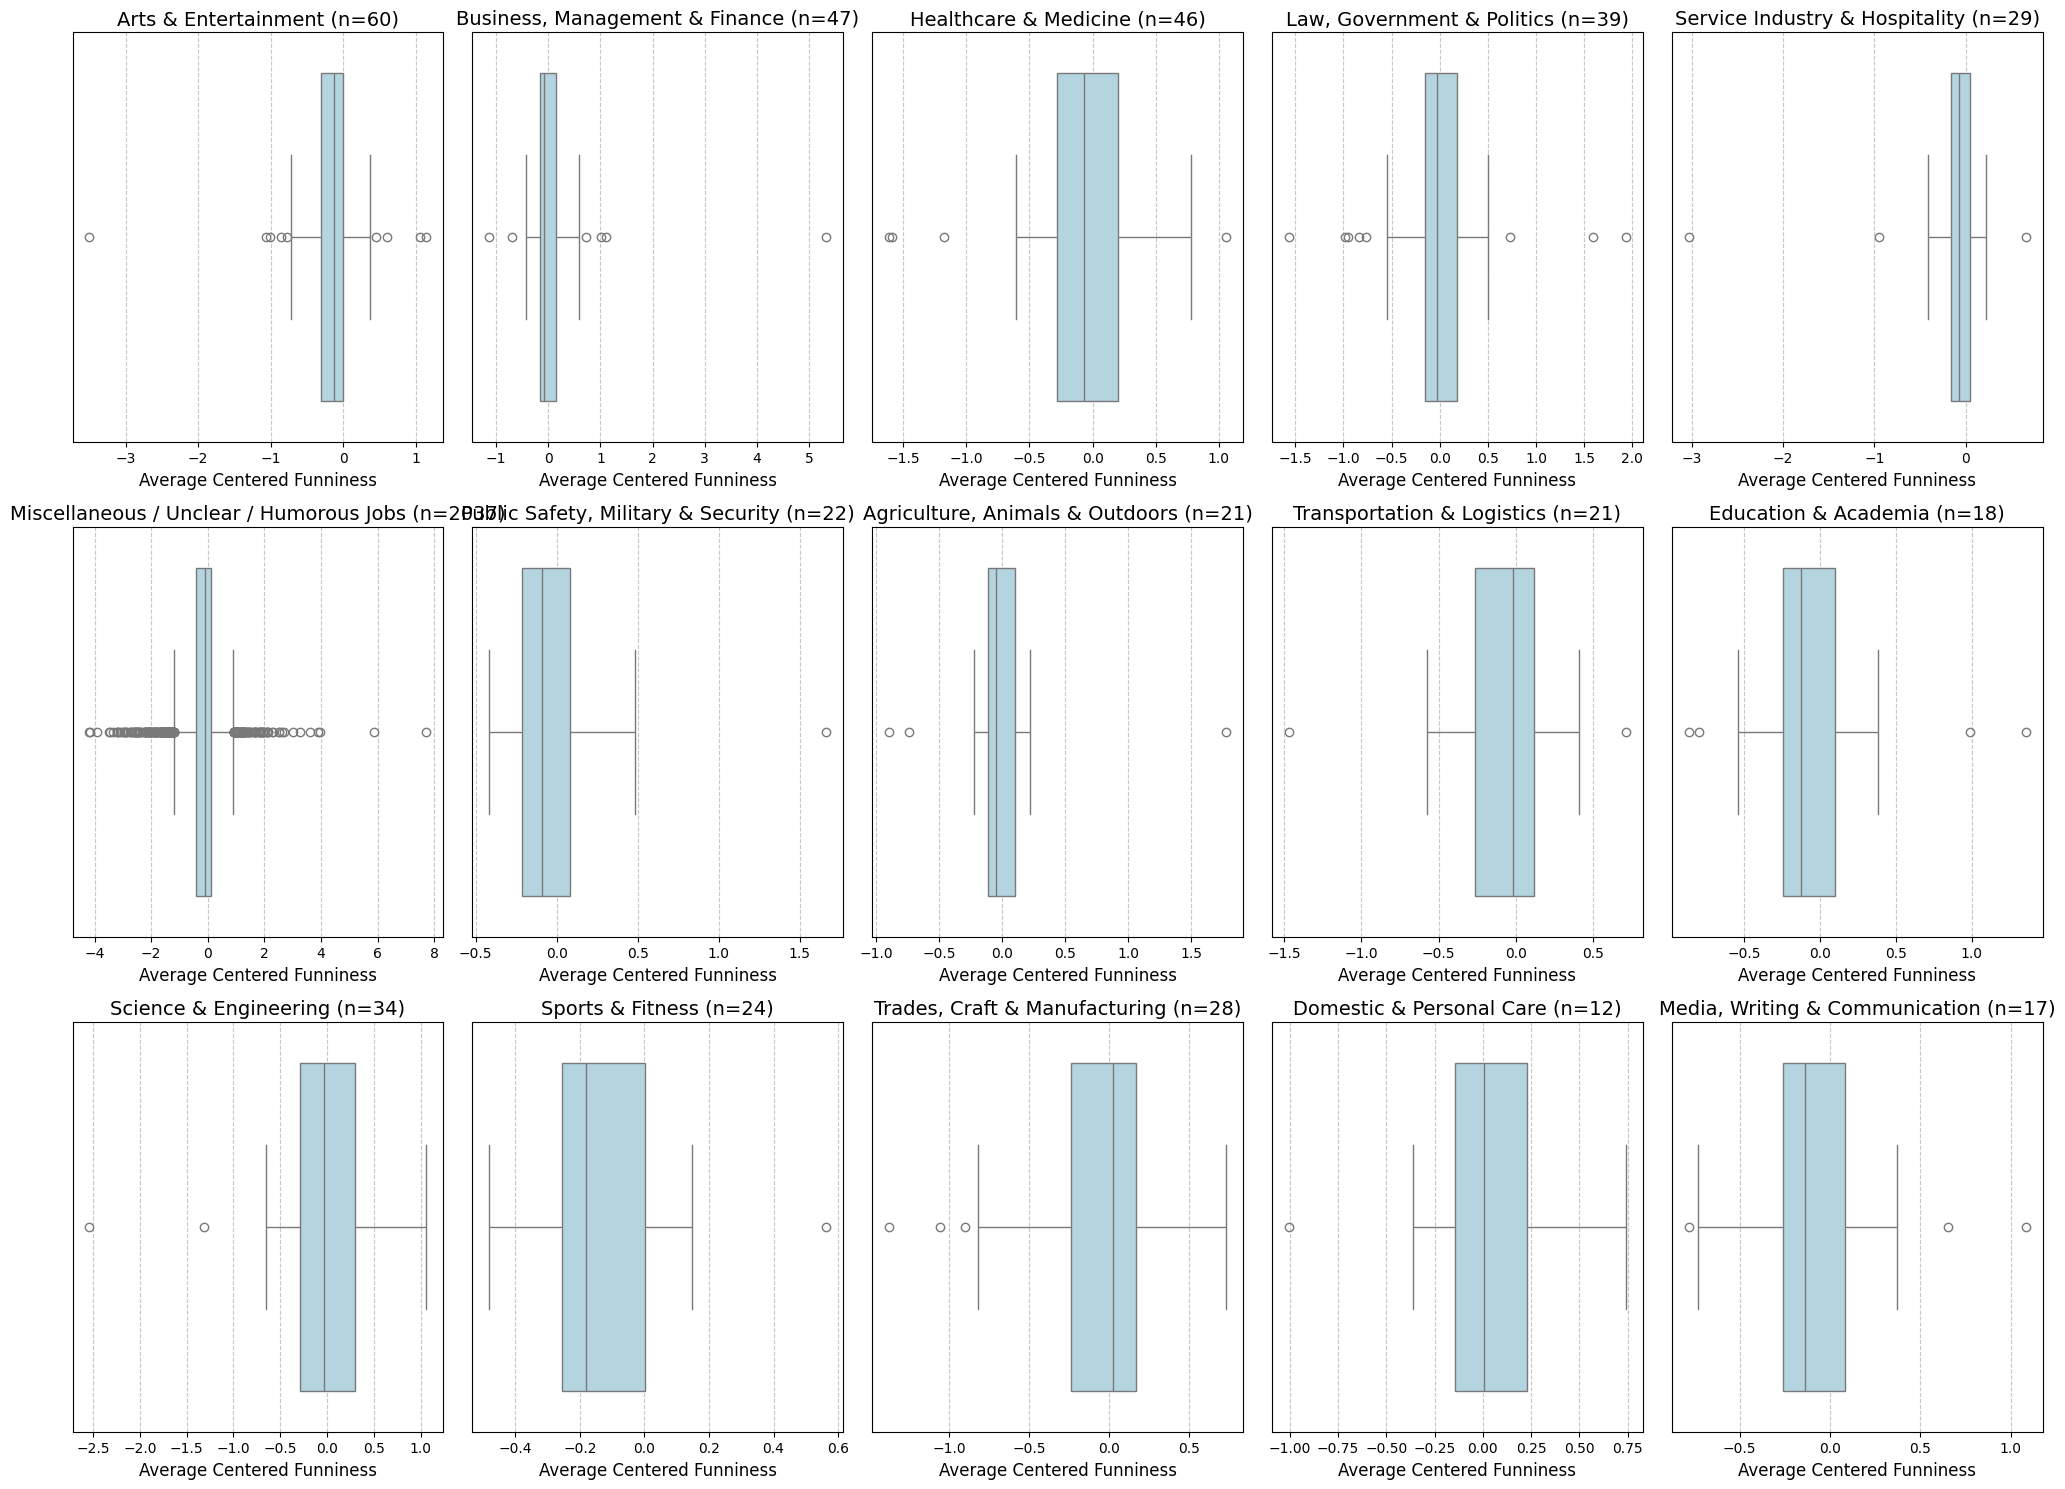

In [88]:
# Graph 1: boxplot of occupation centered scores by field
fig, ax = plt.subplots(nrows = 3, ncols=5, figsize=(20, 15))
categories = occupation_analysis_df['Category'].unique()
for i, category in enumerate(categories):
    row = i // 5
    col = i % 5
    subset = occupation_analysis_df[occupation_analysis_df['Category'] == category]
    sns.boxplot(
        data=subset,
        x='Avg_Funny_Centered',
        ax=ax[row, col],
        color='lightblue'
    )
    ax[row, col].set_title(f"{category} (n={len(subset)})", fontsize=14)
    ax[row, col].set_xlabel("Average Centered Funniness", fontsize=12)
    ax[row, col].set_yticks([])  # Hide y-axis ticks for clarity
    ax[row, col].grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



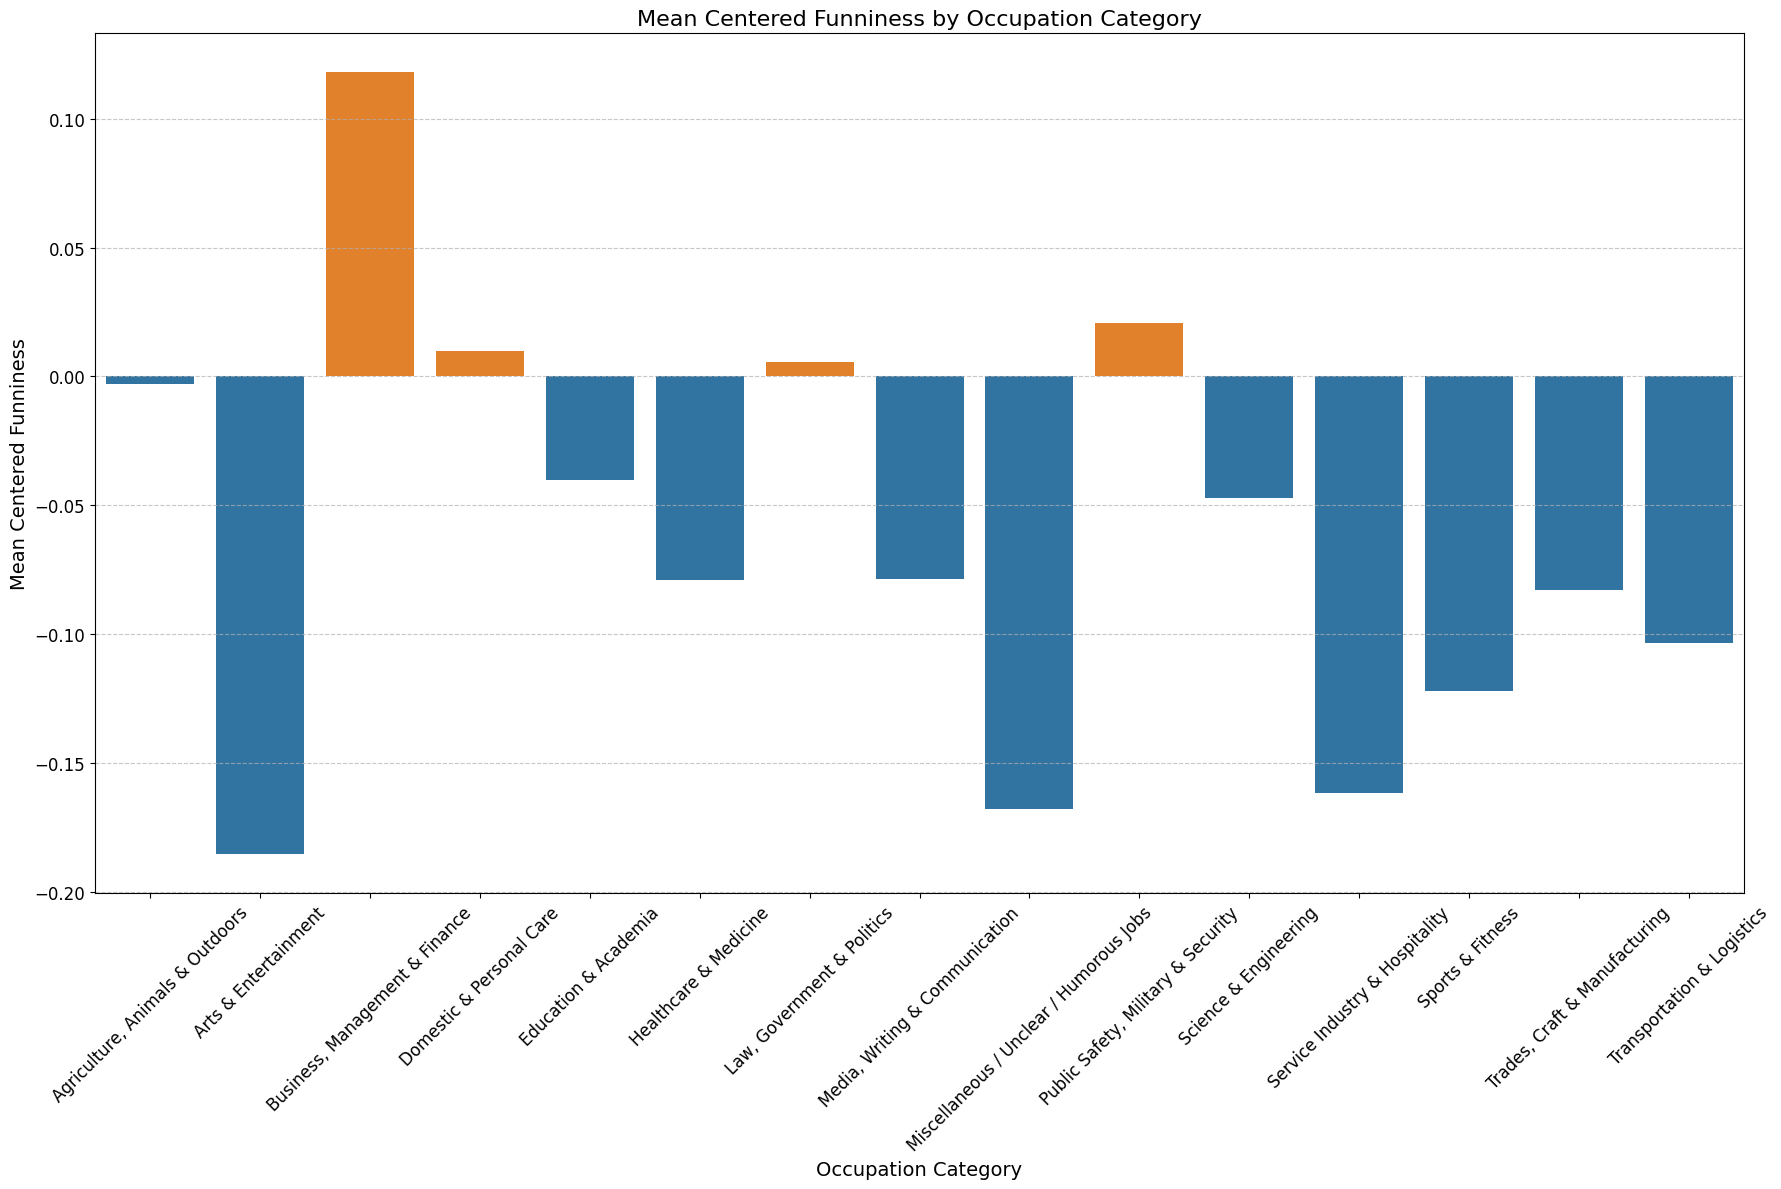

The only occupation categories with positive mean centered funniness are:
Business, Management & Finance: 0.1180
Domestic & Personal Care: 0.0099
Law, Government & Politics: 0.0057
Public Safety, Military & Security: 0.0208


In [98]:
# Graph 2: Bar chart of mean centered funniness by field 
mean_funniness_by_category = occupation_analysis_df.groupby('Category')['Avg_Funny_Centered'].mean().reset_index()

colours = ['navy' if occupation_analysis_df[occupation_analysis_df['Category'] == category]['Avg_Funny_Centered'].mean() >= 0 else 'lightcoral' for category in mean_funniness_by_category['Category']]
plt.figure(figsize=(18, 12))
sns.barplot(
    data=mean_funniness_by_category,
    x='Category',
    y='Avg_Funny_Centered',
    hue=colours,
    legend=False
)
plt.title("Mean Centered Funniness by Occupation Category", fontsize=16)
plt.xlabel("Occupation Category", fontsize=14)
plt.ylabel("Mean Centered Funniness", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("The only occupation categories with positive mean centered funniness are:")
for i, row in mean_funniness_by_category.iterrows():
    if row['Avg_Funny_Centered'] >= 0:
        print(f"{row['Category']}: {row['Avg_Funny_Centered']:.4f}")


---
# <center> Part 4: Temporal trends

For temporal data, we do possess some dates but not all. We will simply assume that each contest came after another, and for temporal information, we can return later.

We will try and see if certain occupational humour spiked during certain times, or if elections had an influence on the occupational humour. We will return to politics at another time as well.

Important events to consider for this temporal segment:
 - 2016 Elections in the US
 - 2016 Harambe zoo? Idk
 - 2020 George Floyd
 - 2019 -> Covid
 - 2020 Elections in the US
 - 2024 Elections
 - Brexit
 - Rise of AI
 - Rise of Tik-Tok and social media
 - Inflation during covid
 - Rise in climate change debates and topics
 - Other political scandals (capitol attack, supreme court contreversies, impeachment and such) We will return to this, but there are some occupations that link to this. 
 - More in depth stuff

1. Temporal trend of categories
2. Temporal trend of selected vocabulary.

There are some more stuff to do!